In [1]:
import json
import glob
import numpy as np
import matplotlib.pyplot as plt

from collections import defaultdict

%matplotlib inline

import keras
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.layers.noise import GaussianNoise
from keras import backend as K

from IPython import display



In [44]:
LAYER_BLOCKS = 0
LAYER_COINS = 1
LAYER_ENEMIES = 2
NLAYERS = 3

class GameMap:
    def __init__(self):
        self.levels = []
        self.widths = []
        self.heights = []
        self.nmaps = 0
        
        with open("Zelda/zelda.json") as f:
            self.tiledefs = json.load(f)
        
        for fname in sorted(glob.glob("Zelda/zelda/zelda_lvl*.txt")):
            #print(fname)
            with open(fname) as f:
                data = [line.strip() for line in f.readlines()]
                self.levels.append(data)
                self.heights.append(len(data))
                self.widths.append(len(data[0]))
                self.nmaps += 1

    def getMaps(self, level=0):
        layers = np.ndarray((self.heights[level], self.widths[level], NLAYERS), dtype=np.bool)
        layers.fill(0)
        for r, row in enumerate(self.levels[level]):
            for c, tile in enumerate(row):
                if tile in ('1','2','3'):
                    layers[r,c,LAYER_ENEMIES] = 1
                elif tile in ('+'):
                    layers[r,c,LAYER_COINS] = 1
                elif tile in ('w'):
                    pass
                else:
                    layers[r,c,LAYER_BLOCKS] = 1
                
        return layers[:,:,LAYER_BLOCKS]
    
    def getMapsRange(self, from_level=0, to_level=None):
        if to_level == None:
            to_level = from_level + 1
        return np.concatenate([self.getMaps(i) for i in range(from_level, to_level)], axis=1)
            
    def getMapsRangeWindowed(self, windowsize = 2, from_level=0, to_level=None):
        if to_level == None:
            to_level = from_level + 1
        a = self.getMapsRange(from_level, to_level)
        windows = np.concatenate([np.roll(a,-shift,axis=1) for shift in range(windowsize)])
        return windows
            

In [45]:
gm = GameMap()
a = gm.getMapsRangeWindowed(4,0,8)
at = a.transpose()


In [46]:
in_out_size = at.shape[1]
hiddensize =2 #int(in_out_size*.25)
model = Sequential()
model.add(Dense(in_out_size/1, input_shape=(in_out_size,)))
model.add(Activation("sigmoid"))

model.add(Dense(in_out_size/2))
model.add(Activation("sigmoid"))

model.add(Dense(hiddensize))
model.add(Activation("sigmoid"))

model.add(Dense(in_out_size/2))
model.add(Activation("sigmoid"))

model.add(Dense(in_out_size))
model.add(Activation("sigmoid"))

# "mse" seems to be the best loss function for the problem
# "RMSprop" seems to be the best, with "adadelta" also good
model.compile(loss='mse', optimizer='RMSprop', metrics=['accuracy'])



In [47]:
model.layers

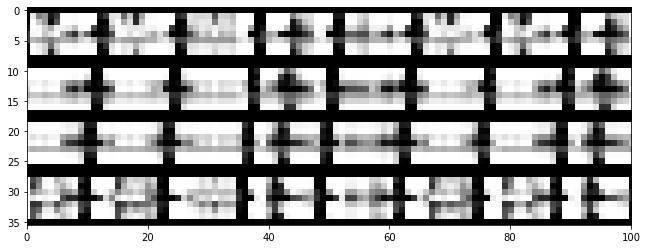

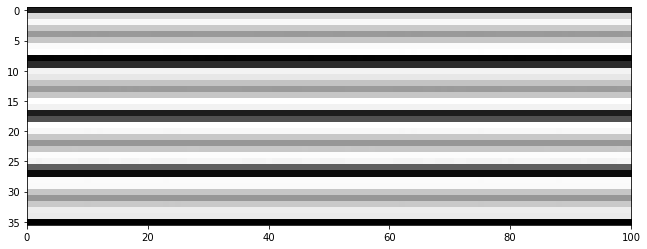

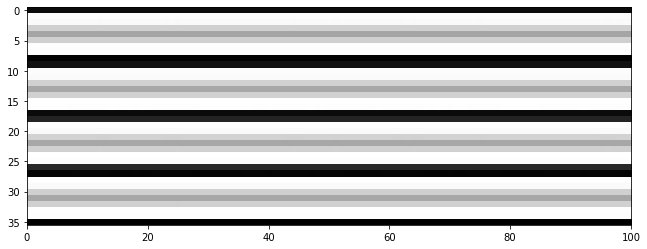

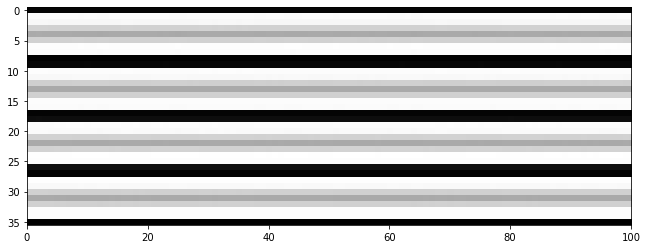

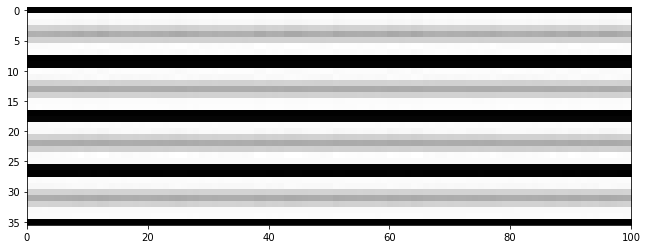

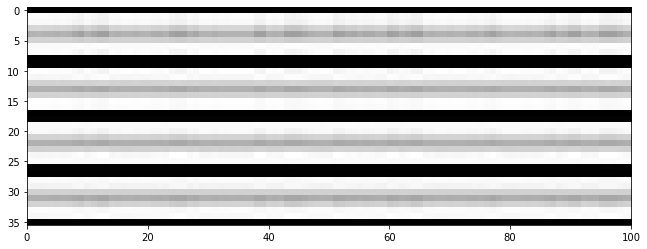

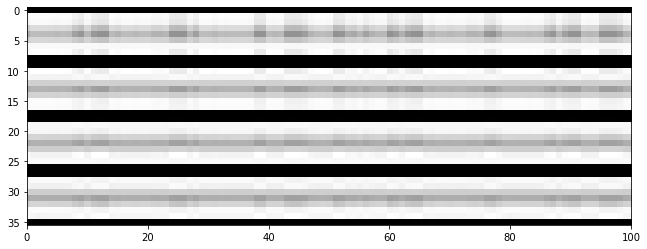

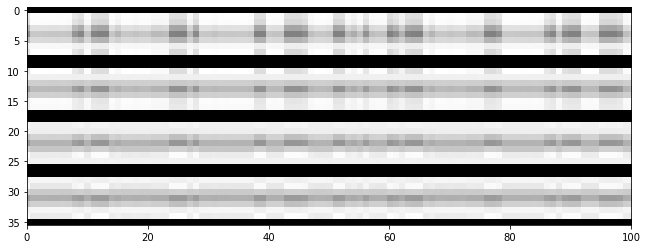

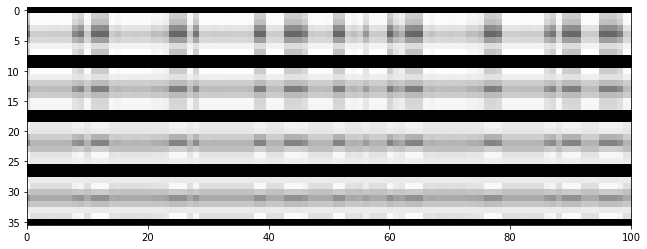

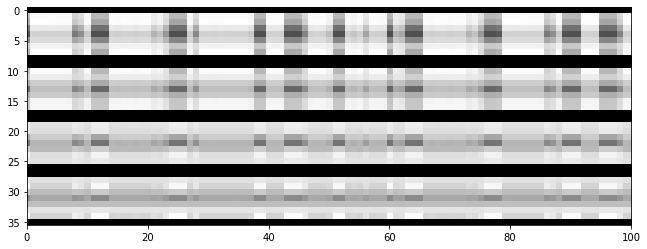

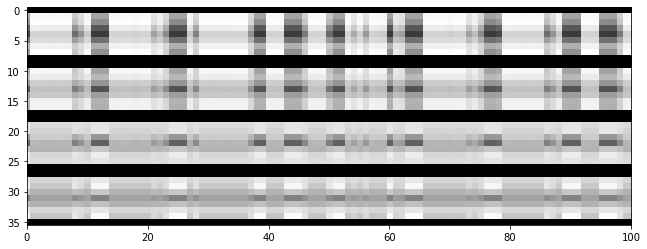

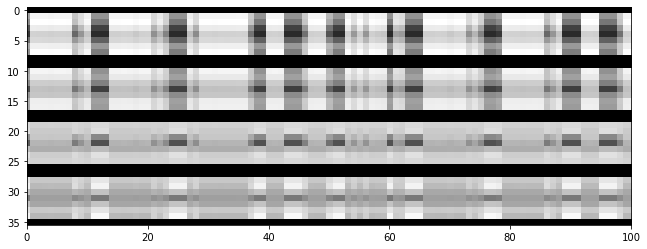

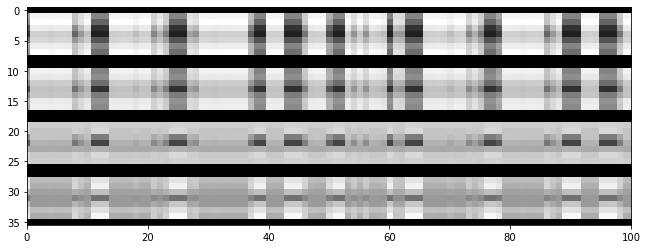

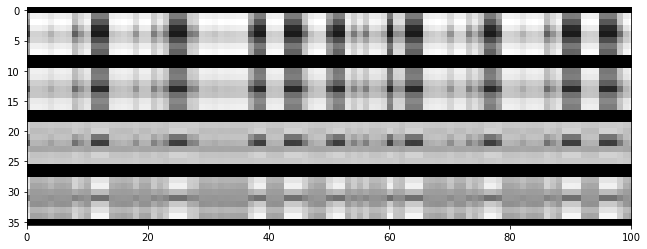

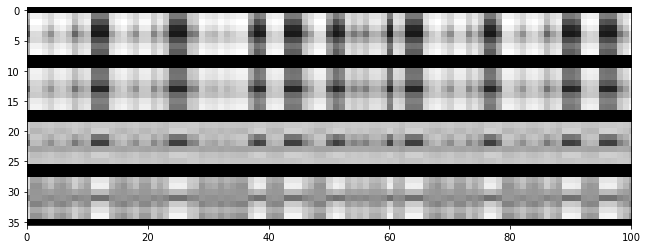

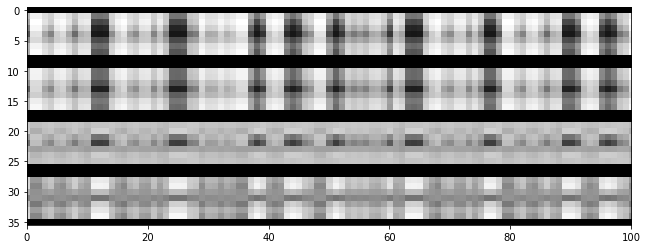

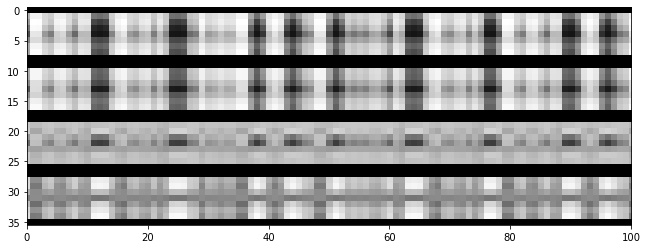

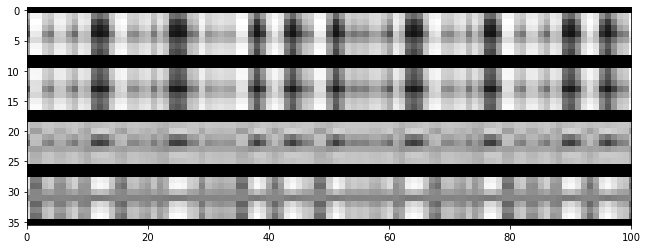

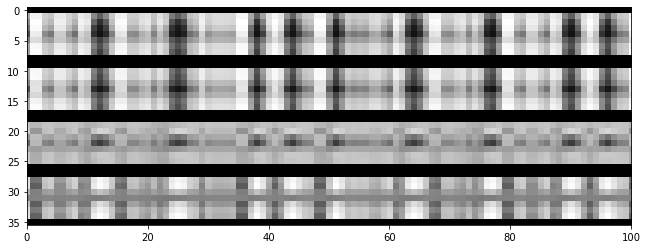

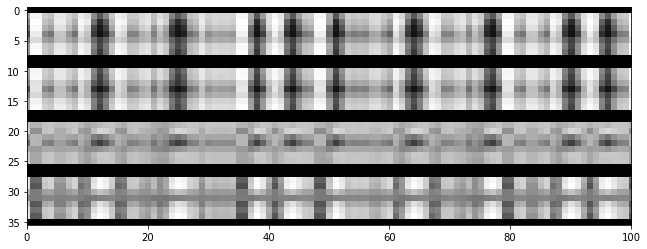

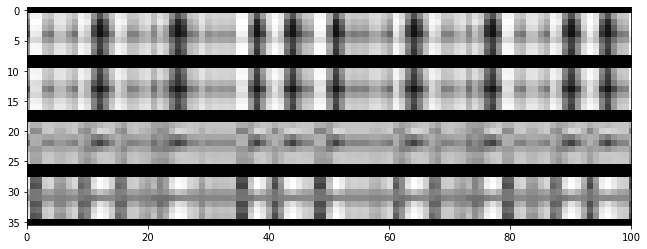

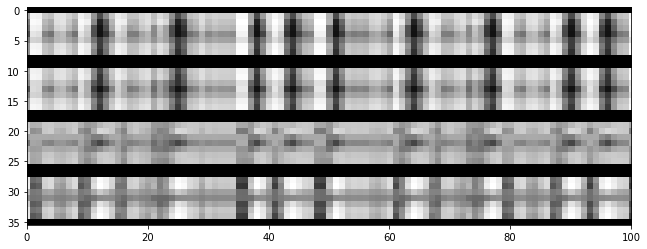

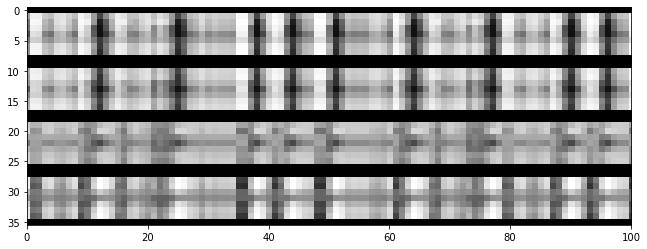

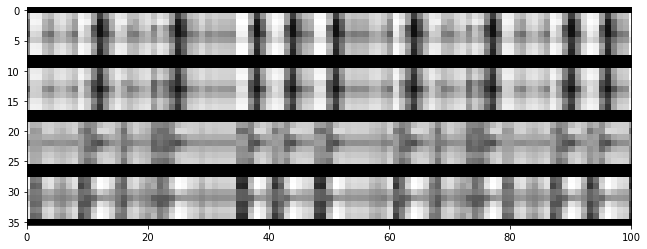

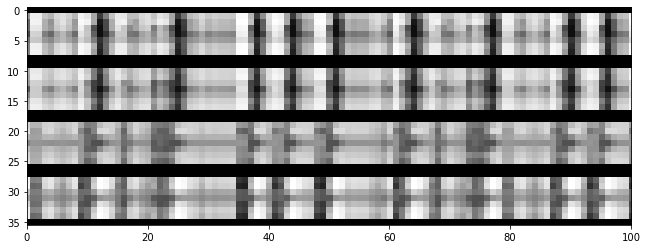

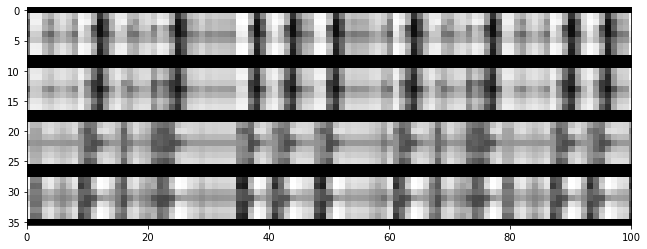

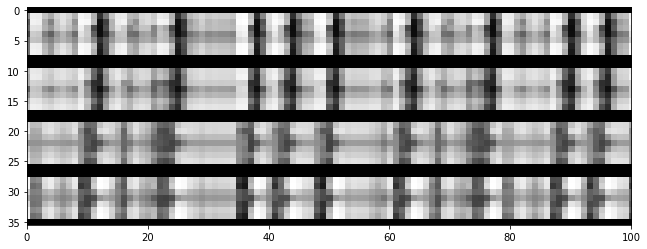

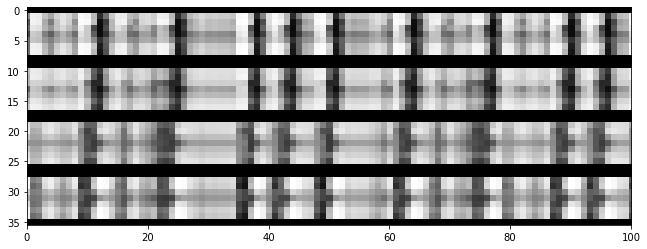

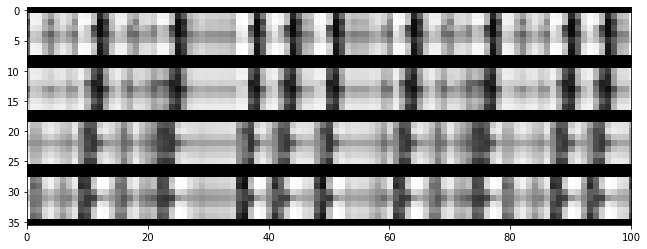

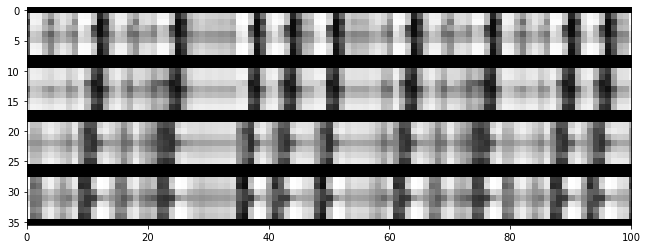

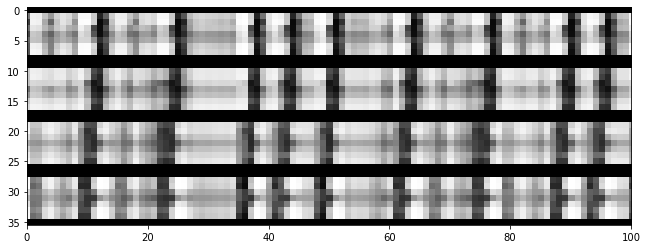

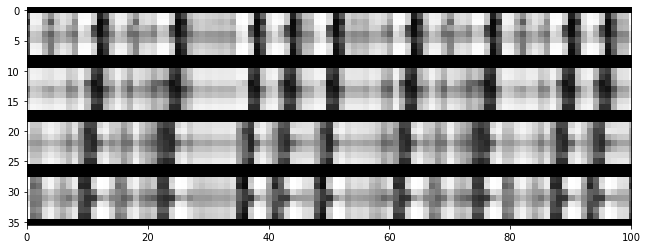

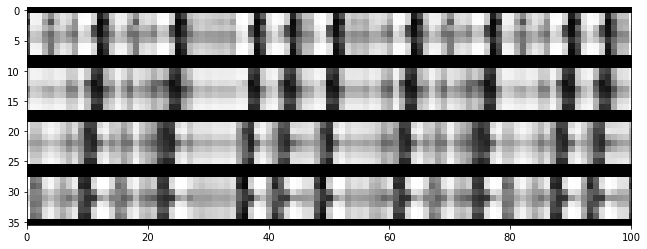

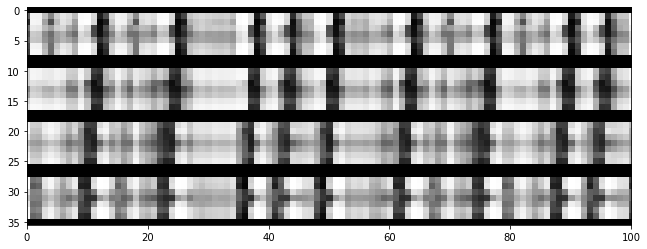

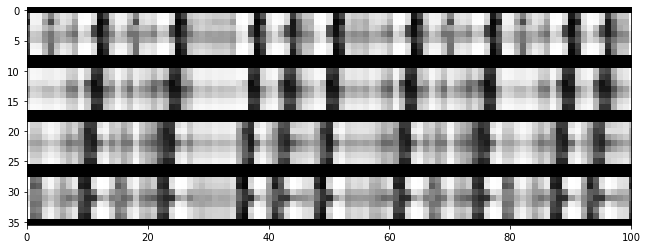

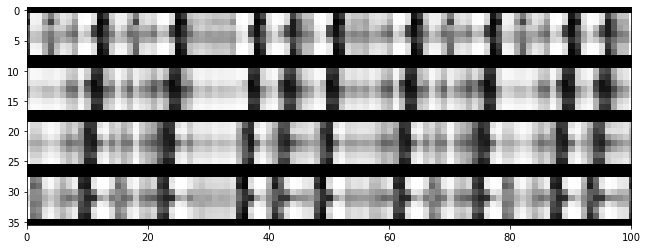

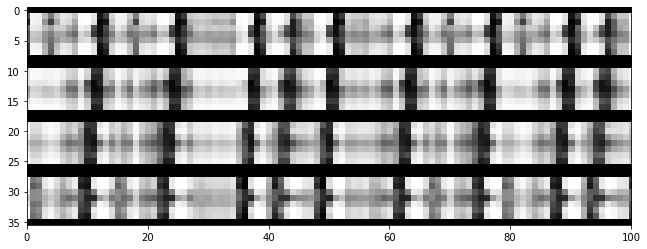

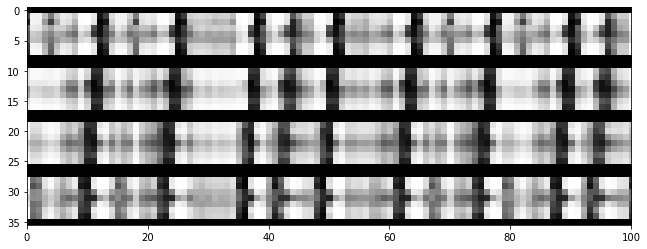

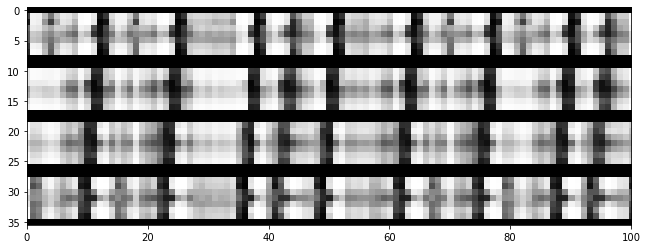

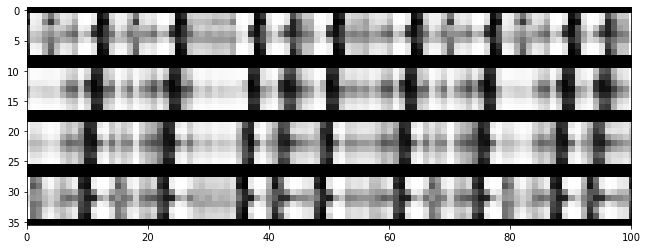

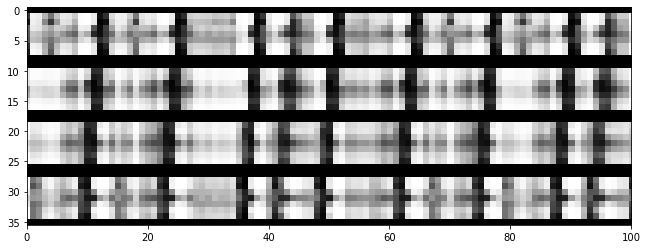

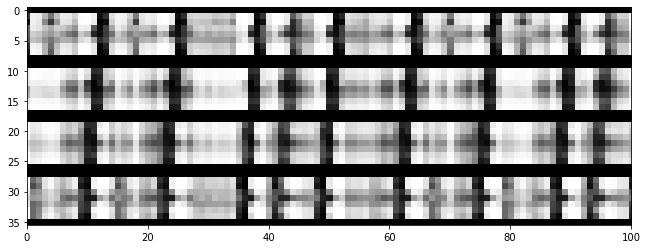

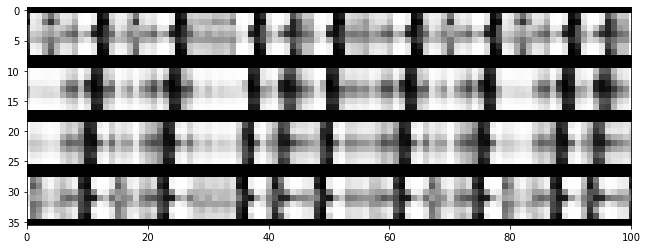

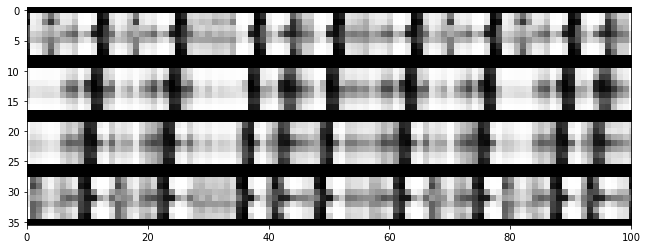

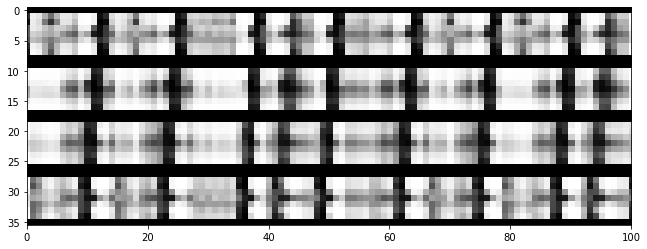

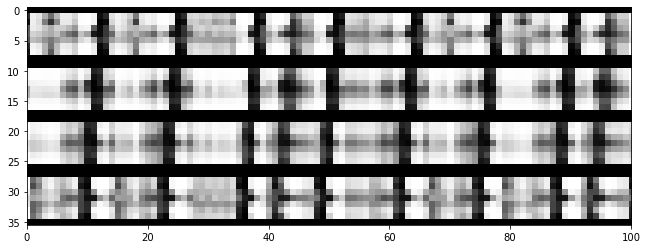

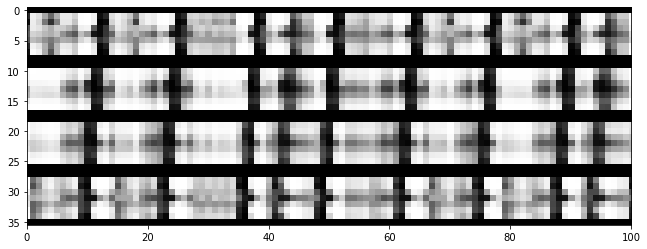

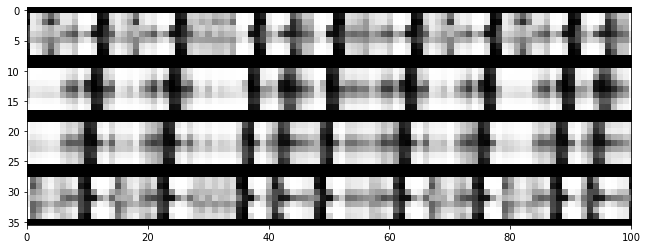

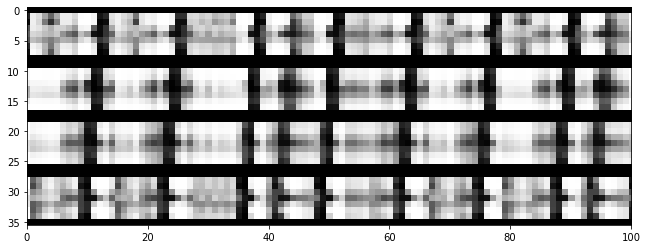

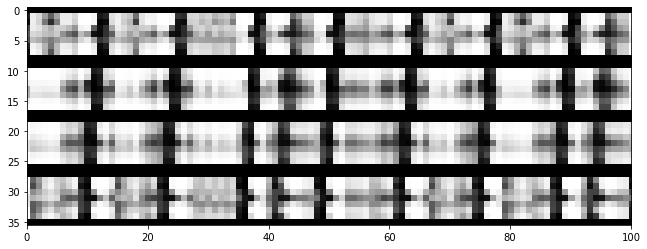

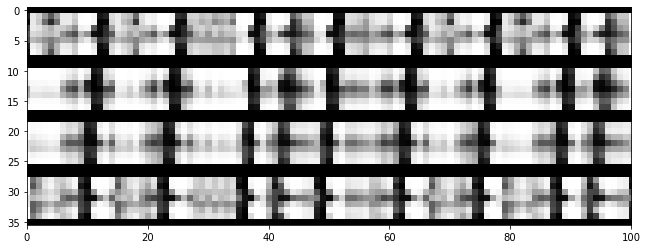

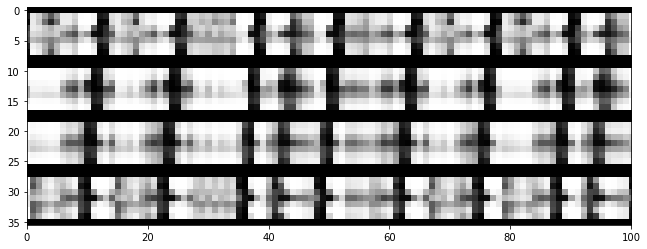

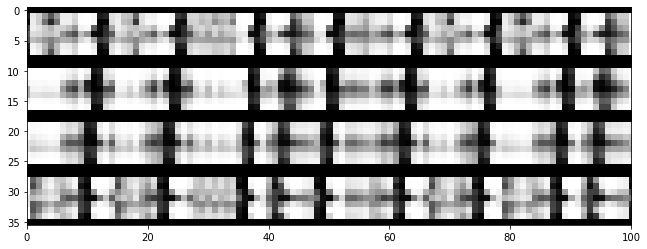

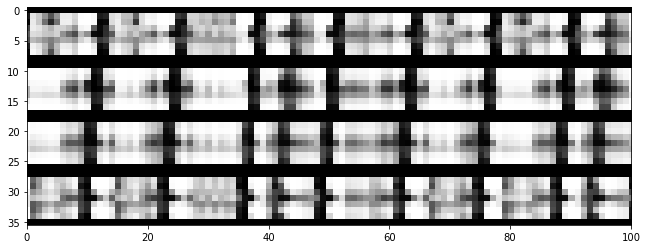

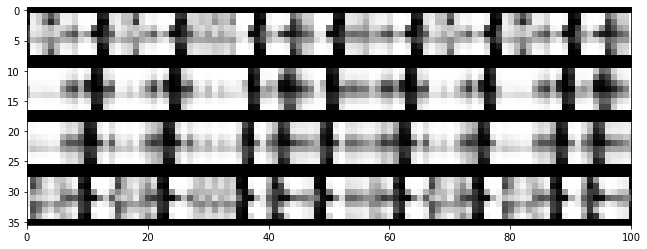

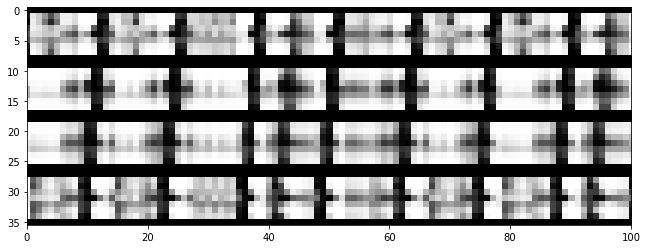

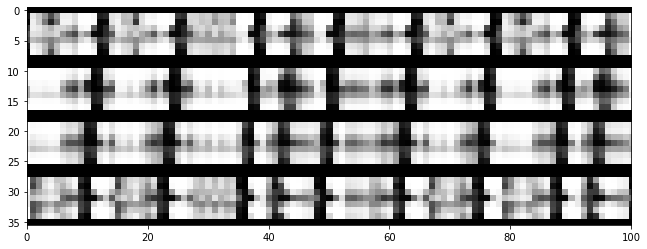

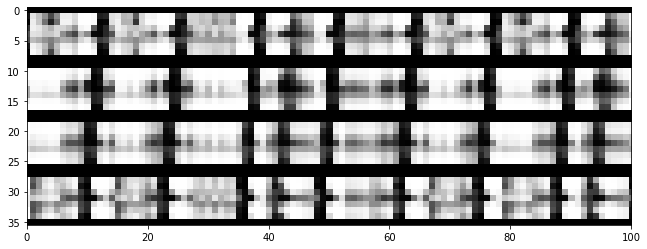

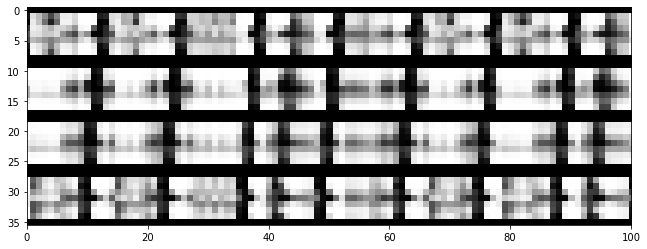

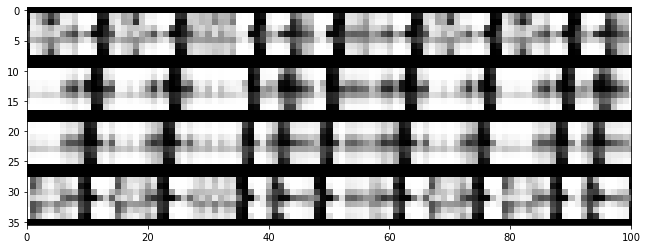

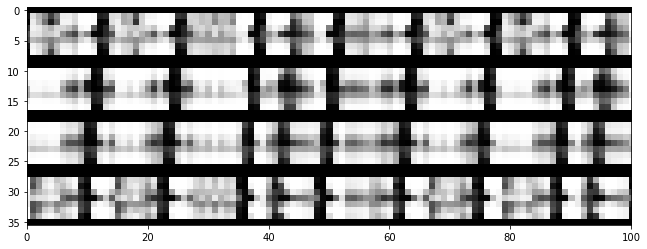

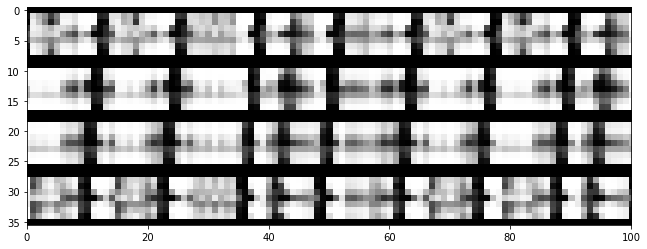

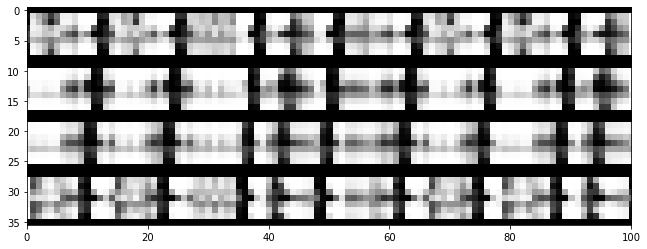

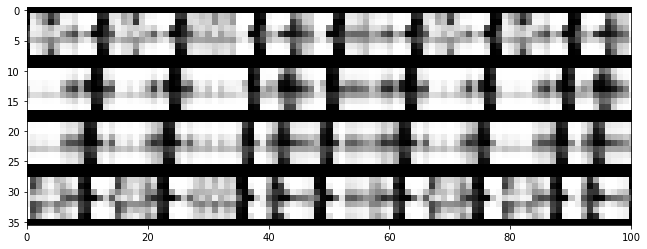

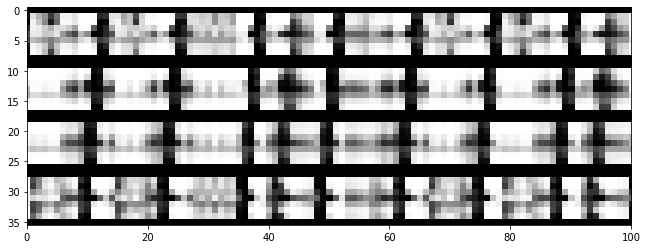

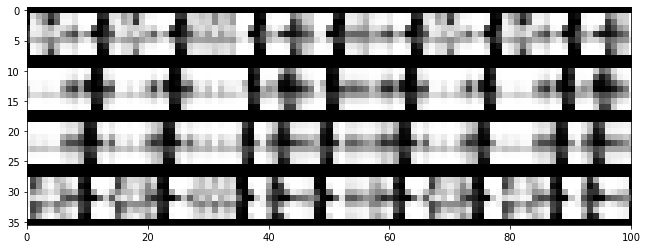

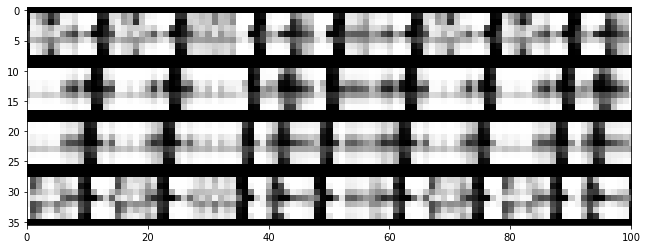

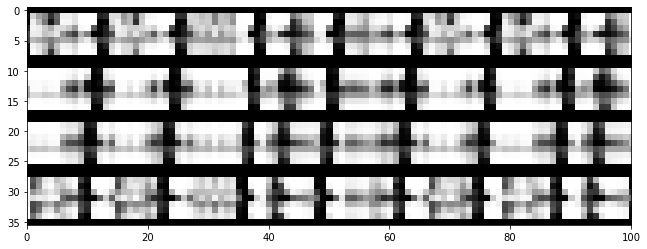

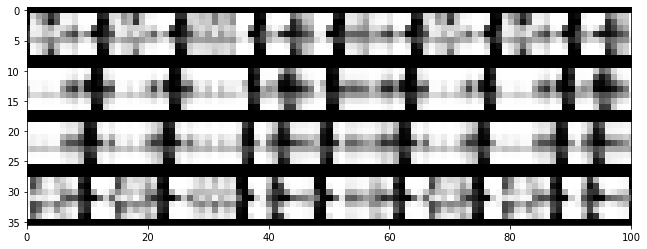

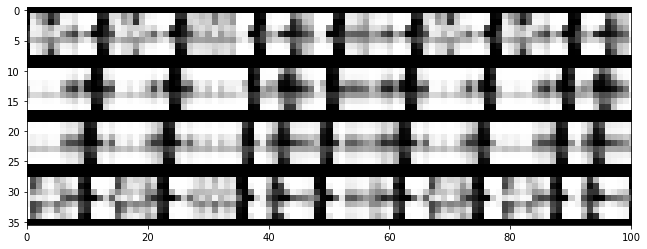

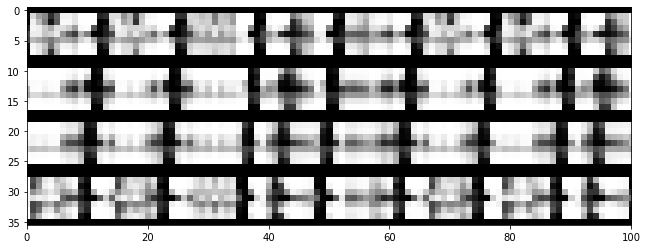

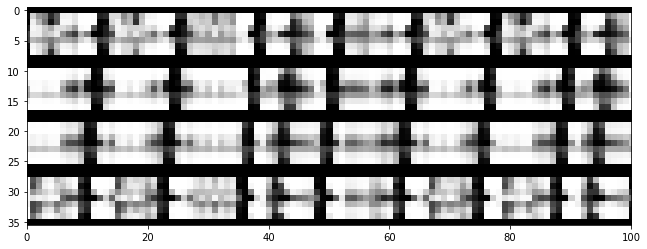

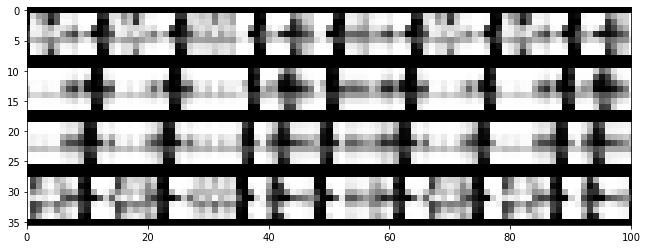

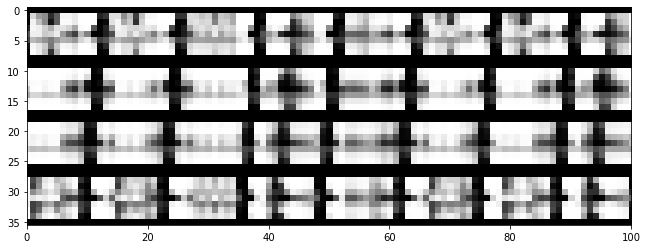

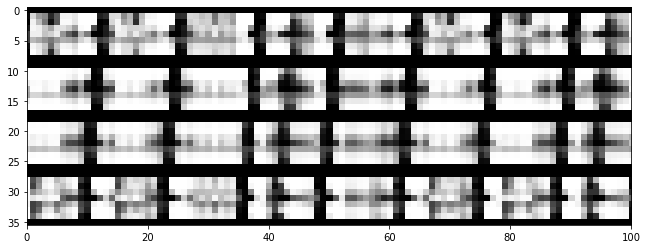

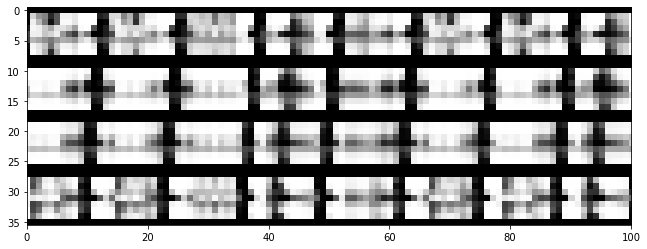

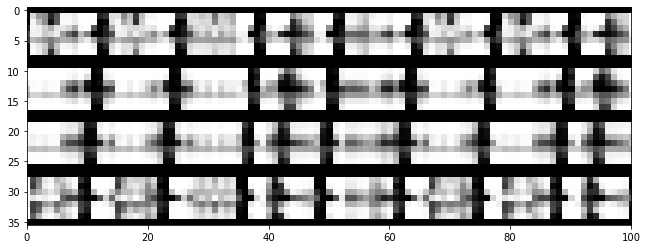

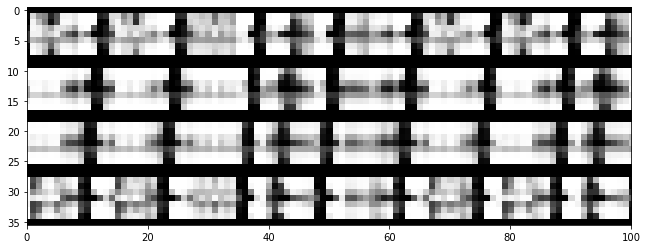

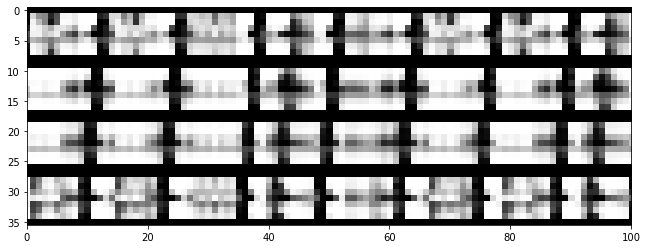

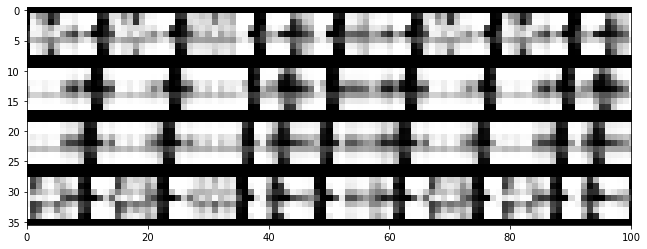

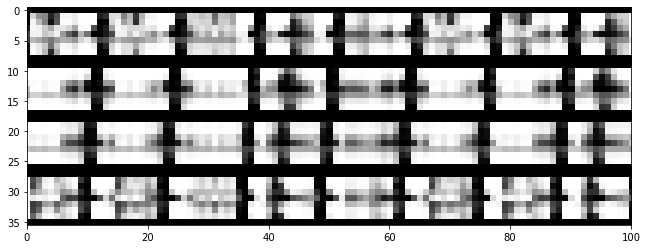

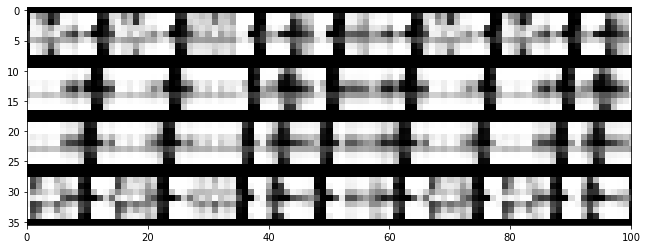

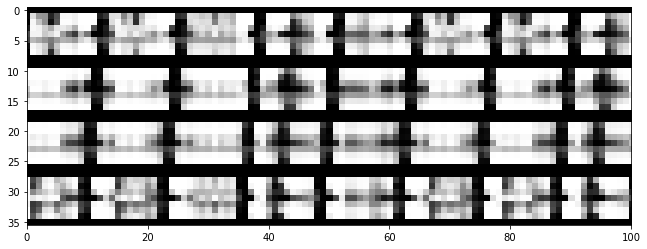

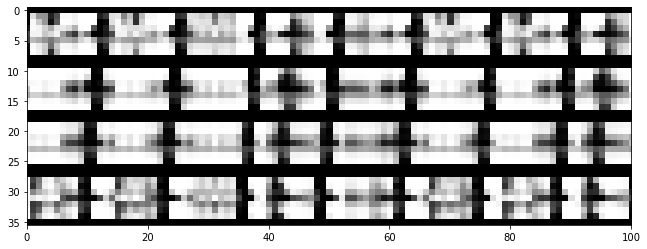

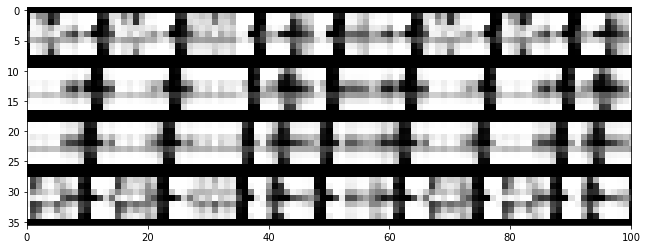

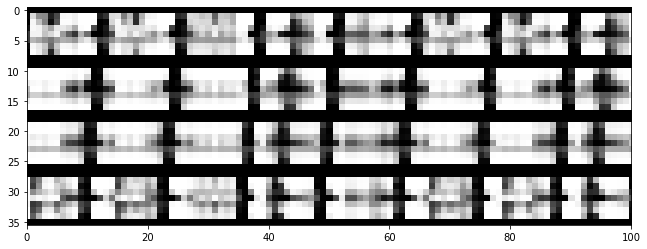

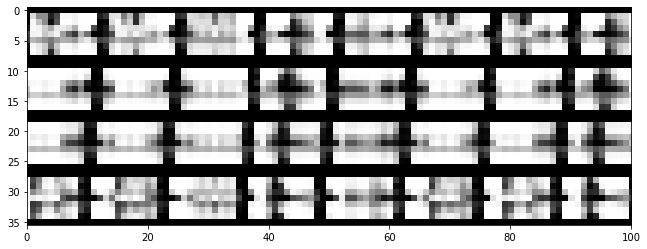

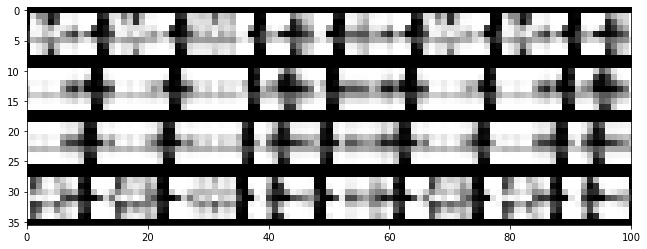

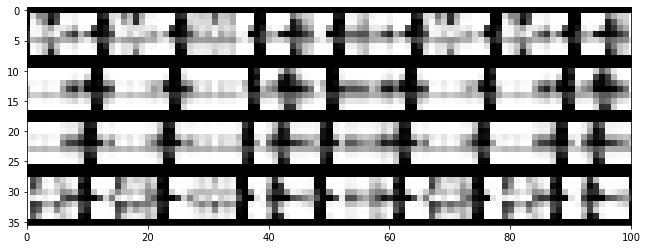

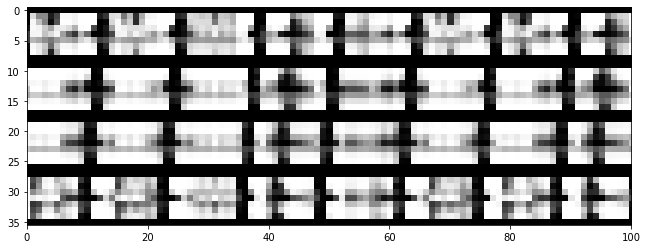

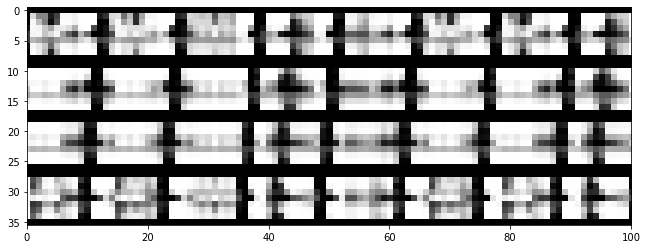

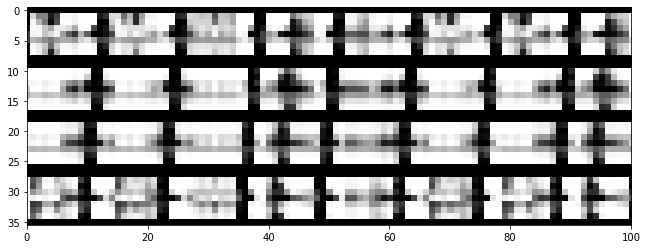

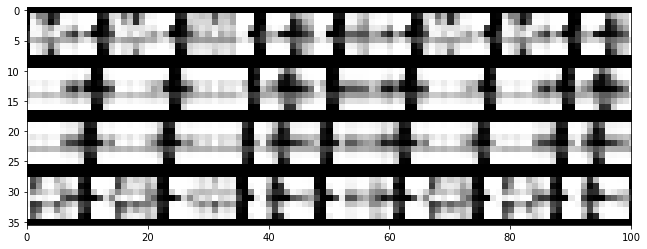

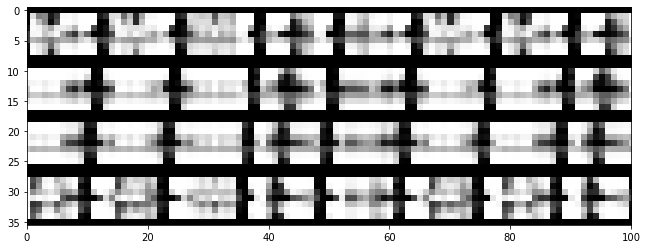

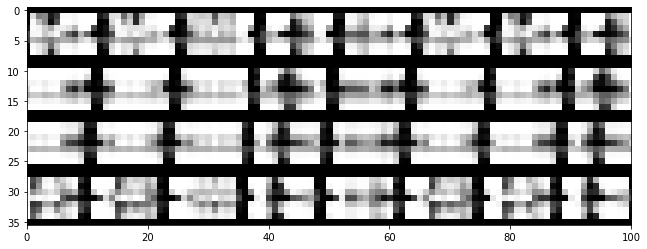

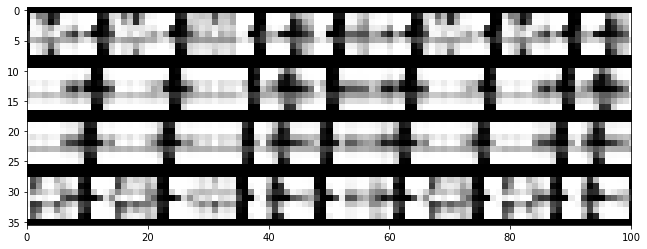

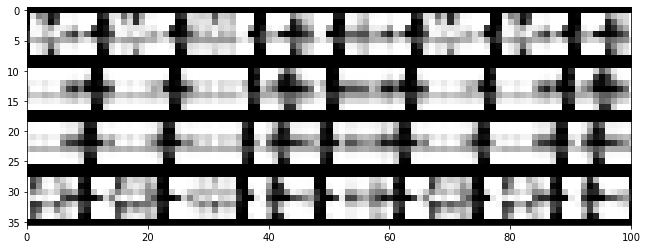

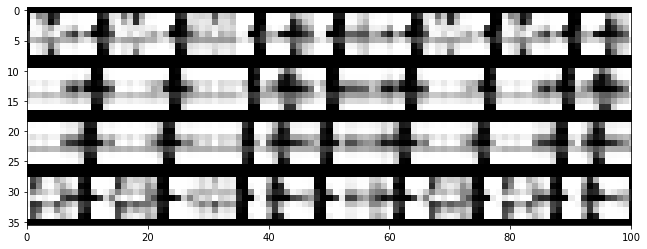

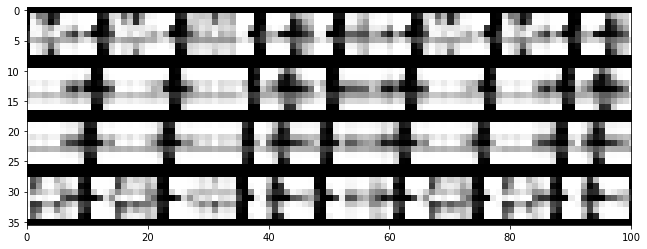

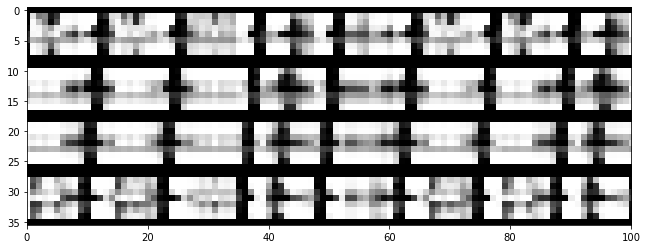

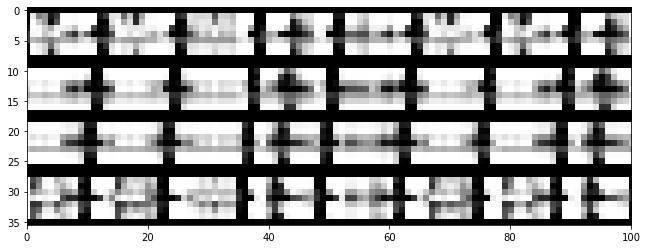

In [48]:
for i in range(100):
    history = model.fit(at, at, epochs=50, batch_size=64, shuffle=True, verbose=False)
    pt = model.predict(at)
    p = pt.transpose()
    fig, axes = plt.subplots(1,1,figsize=(16,4))
    axes.imshow(p,cmap="gray", interpolation="nearest");
    axes.set_xlim(0,100)
    display.clear_output(wait=True)
    display.display(plt.gcf());
    #print((i, history.history['acc'][-1]))
    #axes[1].imshow(a,cmap="gray", interpolation="nearest")

In [49]:
model.save_weights("sk-figure-encoderA.h5", overwrite=True)
with open("sk-figure-encoderA.json", "w") as f:
    f.write(model.to_json())

In [50]:
model.layers[0].get_weights()[1].shape

(36,)

57.08423

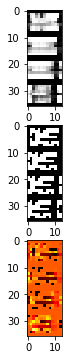

In [51]:
test_a = gm.getMapsRangeWindowed(4, 1)
test_at = test_a.transpose()
test_pt = model.predict(test_at)
test_p = test_pt.transpose()
fig, axes = plt.subplots(3,figsize=(16,6))
axes[0].imshow(test_p,cmap="gray", interpolation="nearest")
axes[1].imshow(test_a,cmap="gray", interpolation="nearest")
axes[2].imshow(test_a-test_p, interpolation="nearest", cmap="hot", vmin=-1, vmax=1)
np.sum(pow(test_a-test_p,2))

In [52]:
model.layers

In [64]:
#modelA = model
#modelB = model
#modelC = model

In [53]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_20 (Dense)             (None, 36)                1332      
_________________________________________________________________
activation_20 (Activation)   (None, 36)                0         
_________________________________________________________________
dense_21 (Dense)             (None, 18)                666       
_________________________________________________________________
activation_21 (Activation)   (None, 18)                0         
_________________________________________________________________
dense_22 (Dense)             (None, 2)                 38        
_________________________________________________________________
activation_22 (Activation)   (None, 2)                 0         
_________________________________________________________________
dense_23 (Dense)             (None, 18)               

In [54]:
model.layers[5].output

<KerasTensor: shape=(None, 2) dtype=float32 (created by layer 'activation_22')>

In [55]:
test_at = test_a.transpose()
print(test_at)

[[False False False False False False False False False False  True  True
   True False  True  True  True False False  True  True False False False
   True  True False False False  True  True  True  True  True  True False]
 [False  True  True  True False  True  True  True False False  True  True
  False False False  True  True False False False  True  True  True  True
   True  True False False  True  True  True  True  True  True False False]
 [False  True  True False False False  True  True False False False  True
   True  True  True  True  True False False  True  True  True  True  True
   True False False False False False  True  True False  True False False]
 [False False  True  True  True  True  True  True False False  True  True
   True  True  True  True False False False False False  True  True False
   True False False False False  True  True  True False  True  True False]
 [False  True  True  True  True  True  True False False False False False
   True  True False  True False Fa

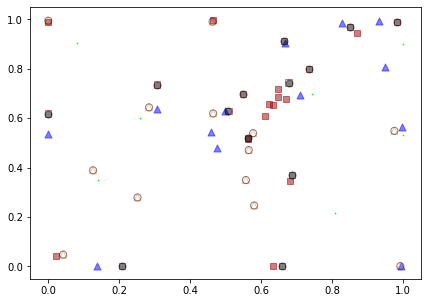

In [63]:
#model = modelB

fig, axes = plt.subplots(1,figsize=(7,5))

#get_hidden_layer_output = K.function([model.layers[0].input,  K.learning_phase()], [model.layers[5].output])
get_hidden_layer_output = K.function([model.layers[0].input], [model.layers[5].output])
xd = 0
yd = 1

if True:
    test_a = gm.getMapsRangeWindowed(4, 0) # W 1-1
    test_at = test_a.transpose()
    hidden_layer_output_A = get_hidden_layer_output([test_at])[0]
    plt.scatter(hidden_layer_output_A[:,xd], hidden_layer_output_A[:,yd], alpha=.5, marker='^', color="#FF8044", s=50)

if True:
    test_a = gm.getMapsRangeWindowed(4, 3) # W 2-1
    test_at = test_a.transpose()
    hidden_layer_output_A = get_hidden_layer_output([test_at])[0]
    plt.scatter(hidden_layer_output_A[:,xd], hidden_layer_output_A[:,yd], alpha=.5, marker='^', color="#FF8040", s=50,
               facecolor='none')



    
if True:
    test_a = gm.getMapsRangeWindowed(4, 2) # W 1-3
    test_at = test_a.transpose()
    hidden_layer_output = get_hidden_layer_output([test_at])[0]
    plt.scatter(hidden_layer_output[:,xd], hidden_layer_output[:,yd], color="#9B0000", alpha=.5, marker="s", s=40)

if True:
    test_a = gm.getMapsRangeWindowed(4, 5) # W 3-3
    test_at = test_a.transpose()
    hidden_layer_output = get_hidden_layer_output([test_at])[0]
    plt.scatter(hidden_layer_output[:,xd], hidden_layer_output[:,yd], color="#9B0000", alpha=.5, marker="s", s=40,
               facecolor='None')
    
if True:
    test_a = gm.getMapsRangeWindowed(4, 1) # W 1-2
    test_at = test_a.transpose()
    hidden_layer_output_B = get_hidden_layer_output([test_at])[0]
    plt.scatter(hidden_layer_output_B[:,xd], hidden_layer_output_B[:,yd], color="black", alpha=.5, marker="o", s=50)

    
if True:
    test_a = gm.getMapsRangeWindowed(4, 7) # W 4-2
    test_at = test_a.transpose()
    hidden_layer_output = get_hidden_layer_output([test_at])[0]
    plt.scatter(hidden_layer_output[:,xd], hidden_layer_output[:,yd], color="black", alpha=.5, marker="o", s=50, 
                facecolor='None')

plt.scatter( 0.80908334,  0.21475835, marker=".", s=2, color='#00FF00')
plt.scatter( .082,.905, marker=".", s=2, color='#00FF00')
plt.scatter( .26,.6, marker=".", s=2, color='#00FF00')
plt.scatter( .14,.35, marker=".", s=2, color='#00FF00')
plt.scatter( 1,.9, marker=".", s=2, color='#00FF00')
plt.scatter( 0.74222749,  0.69727808, marker=".", s=2, color='#00FF00')
plt.scatter( 1,  0.53, marker=".", s=2, color='#00FF00')

plt.xlim(-0.05,1.05)
plt.ylim(-0.05,1.05)

plt.savefig("sk-hiddenlayerviz-h.pdf")

In [58]:
# make some fake input!
h = np.ndarray(shape=(150,2))
h[:,0] = np.random.normal(loc=hidden_layer_output_B[8,0], scale=2, size=150)
h[:,1] = np.random.normal(loc=hidden_layer_output_B[8,1], scale=2, size=150)
#h[:,0].fill(hidden_layer_output_B[8,0])
#h[:,1].fill(hidden_layer_output_B[8,1])
hidden_layer_output_B[8,0], hidden_layer_output_B[8,1]

(0.50825685, 0.628521)

In [59]:
test_a = gm.getMapsRangeWindowed(4, 0) # W 1-1
test_at = test_a.transpose()
hidden_layer_output_A = get_hidden_layer_output([test_at])[0]
hidden_layer_output_A[0,:]



array([0.99793506, 0.5630456 ], dtype=float32)

In [60]:
h = np.array([[0.80908334,  0.21475835],
              [.26,.6],
              [.082,.905],
              [.14,.35],
              [1,.53],
              [0.74222749,  0.69727808],
              [1,.9]
             ])

inject_fake_hidden = K.function([model.layers[6].input],
                                [model.layers[-1].output])

#X = inject_fake_hidden([hidden_layer_output])[0].transpose()
X = inject_fake_hidden([h,0])[0].transpose()

th = .4
X[ X <= th] = 0
X[ X > th] = 1

for i in [-1]: #xrange(h.shape[0]):
    XX = X[:,i].reshape((4,14)).transpose()
    plt.imshow(XX, cmap="gray", interpolation="nearest")
    plt.xticks([])
    plt.yticks([])
    plt.savefig("window-%f-%f.pdf" % (h[i,0], h[i,1]))


Note that input tensors are instantiated via `tensor = tf.keras.Input(shape)`.
The tensor that caused the issue was: activation_22/Sigmoid:0


ValueError: Graph disconnected: cannot obtain value for tensor KerasTensor(type_spec=TensorSpec(shape=(None, 36), dtype=tf.float32, name='dense_20_input'), name='dense_20_input', description="created by layer 'dense_20_input'") at layer "dense_20". The following previous layers were accessed without issue: []

Note that input tensors are instantiated via `tensor = tf.keras.Input(shape)`.
The tensor that caused the issue was: dense_22/BiasAdd:0


ValueError: Graph disconnected: cannot obtain value for tensor KerasTensor(type_spec=TensorSpec(shape=(None, 36), dtype=tf.float32, name='dense_20_input'), name='dense_20_input', description="created by layer 'dense_20_input'") at layer "dense_20". The following previous layers were accessed without issue: []

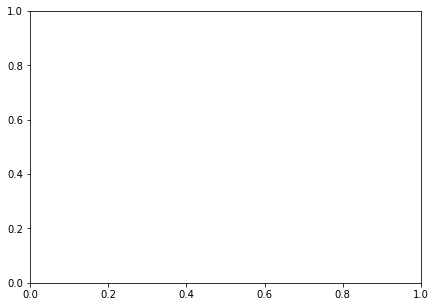

In [61]:
fig, axes = plt.subplots(1,figsize=(7,5))
inject_fake_hidden = K.function([model.layers[5].input],
                                [model.layers[-1].output])

inject_fake_hidden([hidden_layer_output])

if True:
    test_a = gm.getMapsRangeWindowed(4, 0, 1)
    test_at = test_a.transpose()
    hidden_layer_output = get_hidden_layer_output([test_at])[0]
    plt.scatter(hidden_layer_output[:,0], hidden_layer_output[:,1], alpha=1)

if True:
    test_a = gm.getMapsRangeWindowed(4, 1, 2)
    test_at = test_a.transpose()
    hidden_layer_output = get_hidden_layer_output([test_at])[0]
    plt.scatter(hidden_layer_output[:,0], hidden_layer_output[:,1], color="green", alpha=1)

if True:
    test_a = gm.getMapsRangeWindowed(4, 2, 3)
    test_at = test_a.transpose()
    hidden_layer_output = get_hidden_layer_output([test_at])[0]
    plt.scatter(hidden_layer_output[:,0], hidden_layer_output[:,1], color="red", alpha=1)

if False:
    test_a = gm.getMapsRangeWindowed(4, 3, 4)
    test_at = test_a.transpose()
    hidden_layer_output = get_hidden_layer_output([test_at])[0]
    plt.scatter(hidden_layer_output[:,0], hidden_layer_output[:,1], color="orange", alpha=.5)



IndexError: list index out of range

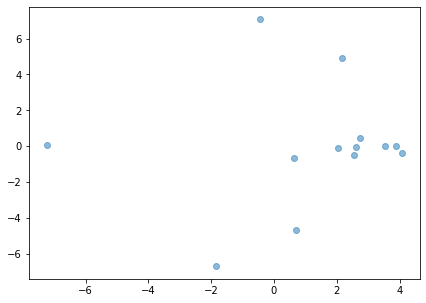

In [65]:
fig, axes = plt.subplots(1,figsize=(7,5))

get_hidden_layer_output = K.function([model.layers[0].input],
                                  [model.layers[4].output])

test_a = gm.getMapsRangeWindowed(4, 2, 3)
test_at = test_a.transpose()
hidden_layer_output = get_hidden_layer_output([test_at])[0]
plt.scatter(hidden_layer_output[:,0], hidden_layer_output[:,1], alpha=.5)

if False:
    test_a = gm.getMapsRangeWindowed(4, 1, 2)
    test_at = test_a.transpose()
    hidden_layer_output = get_hidden_layer_output([test_at])[0]
    plt.scatter(hidden_layer_output[:,0], hidden_layer_output[:,1], color="green", alpha=.5)

if False:
    test_a = gm.getMapsRangeWindowed(4, 2, 3)
    test_at = test_a.transpose()
    hidden_layer_output = get_hidden_layer_output([test_at])[0]
    plt.scatter(hidden_layer_output[:,0], hidden_layer_output[:,1], color="red", alpha=.5)


test_a = gm.getMapsRangeWindowed(4, 5, 6)
test_at = test_a.transpose()
hidden_layer_output = get_hidden_layer_output([test_at])[0]
plt.scatter(hidden_layer_output[:,0], hidden_layer_output[:,1], color="orange", alpha=.5)



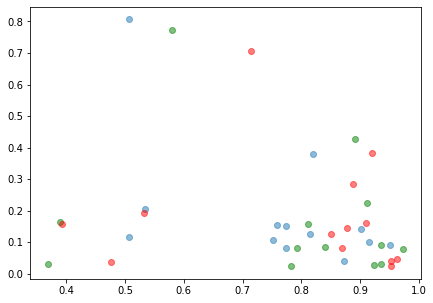

In [66]:
fig, axes = plt.subplots(1,figsize=(7,5))

get_hidden_layer_output = K.function([model.layers[0].input],
                                  [model.layers[1].output])

if True:
    test_a = gm.getMapsRangeWindowed(4, 1, 2)
    test_at = test_a.transpose()
    hidden_layer_output = get_hidden_layer_output([test_at])[0]
    plt.scatter(hidden_layer_output[:,0], hidden_layer_output[:,1], alpha=.5)

if True:
    test_a = gm.getMapsRangeWindowed(4, 0, 1)
    test_at = test_a.transpose()
    hidden_layer_output = get_hidden_layer_output([test_at])[0]
    plt.scatter(hidden_layer_output[:,0], hidden_layer_output[:,1], color="green", alpha=.5)

if True:
    test_a = gm.getMapsRangeWindowed(4, 3, 4)
    test_at = test_a.transpose()
    hidden_layer_output = get_hidden_layer_output([test_at])[0]
    plt.scatter(hidden_layer_output[:,0], hidden_layer_output[:,1], color="red", alpha=.5)

if False:
    test_a = gm.getMapsRangeWindowed(4, 7, 8)
    test_at = test_a.transpose()
    hidden_layer_output = get_hidden_layer_output([test_at])[0]
    plt.scatter(hidden_layer_output[:,0], hidden_layer_output[:,1], color="orange", alpha=.5)



IndexError: list index out of range

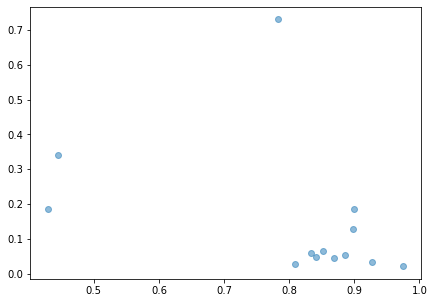

In [67]:
fig, axes = plt.subplots(1,figsize=(7,5))

get_hidden_layer_output = K.function([model.layers[0].input],
                                  [model.layers[1].output])

test_a = gm.getMapsRangeWindowed(4, 2, 3)
test_at = test_a.transpose()
hidden_layer_output = get_hidden_layer_output([test_at])[0]
plt.scatter(hidden_layer_output[:,0], hidden_layer_output[:,1], alpha=.5)

if False:
    test_a = gm.getMapsRangeWindowed(4, 1, 2)
    test_at = test_a.transpose()
    hidden_layer_output = get_hidden_layer_output([test_at])[0]
    plt.scatter(hidden_layer_output[:,0], hidden_layer_output[:,1], color="green", alpha=.5)

if False:
    test_a = gm.getMapsRangeWindowed(4, 2, 3)
    test_at = test_a.transpose()
    hidden_layer_output = get_hidden_layer_output([test_at])[0]
    plt.scatter(hidden_layer_output[:,0], hidden_layer_output[:,1], color="red", alpha=.5)


test_a = gm.getMapsRangeWindowed(4, 9, 10)
test_at = test_a.transpose()
hidden_layer_output = get_hidden_layer_output([test_at])[0]
plt.scatter(hidden_layer_output[:,0], hidden_layer_output[:,1], color="orange", alpha=.5)



In [68]:
# classify each window
test_a = gm.getMapsRangeWindowed(4, 0, 14)
test_at = test_a.transpose()

d = {}

get_hidden_layer_output = K.function([model.layers[0].input,  K.learning_phase()], [model.layers[6].output])
h = get_hidden_layer_output([test_at,0])[0]
h[ h < .5] = 0
h[ h >= .5] = 1
h[:,0] *= 8
h[:,1] *= 4
h[:,2] *= 2
classes = h.sum(axis=1, dtype="int")
print(np.unique(classes))

for i, c in enumerate(classes):            
    key = tuple(test_at[i])
    if not d.has_key(c):
        d[c] = defaultdict(int)        
    d[c][key] += 1
    



IndexError: list index out of range

In [69]:
def displayclass(d, class_id, nshow=10):
    fig, axes = plt.subplots(1, nshow,figsize=(8,2))
    i =0
    bin_class = bin(class_id)[2:]
    bin_class = "0"*(4-len(bin_class))+bin_class
    axes[i].set_ylabel("%d = %0.4s" % (class_id, bin_class))
    for key, value in sorted(d[class_id].items(), key=lambda kv: kv[1], reverse=True):
        axes[i].imshow(np.reshape(key, (4,14)).transpose(), cmap="gray", interpolation="nearest")
        axes[i].set_title(value)

        axes[i].get_xaxis().set_visible(False)
        axes[i].get_yaxis().set_ticks([])
        i += 1
        if i == nshow:
            break

In [70]:
for key in d.iterkeys():
    displayclass(d, key)

NameError: name 'd' is not defined

In [71]:
displayclass(d,1)

NameError: name 'd' is not defined

In [72]:
displayclass(d, 3)

NameError: name 'd' is not defined

In [73]:
displayclass(d, 8)

NameError: name 'd' is not defined

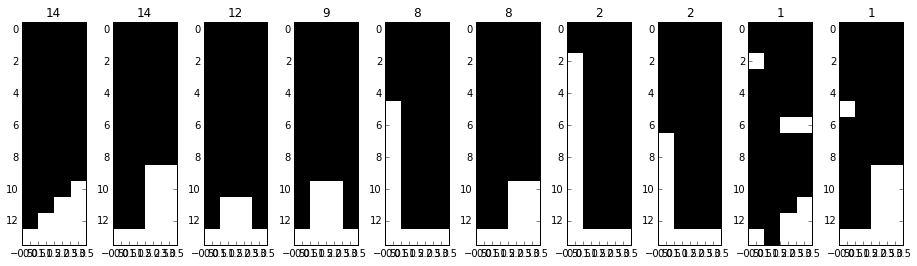

In [246]:
displayclass(d, 9)

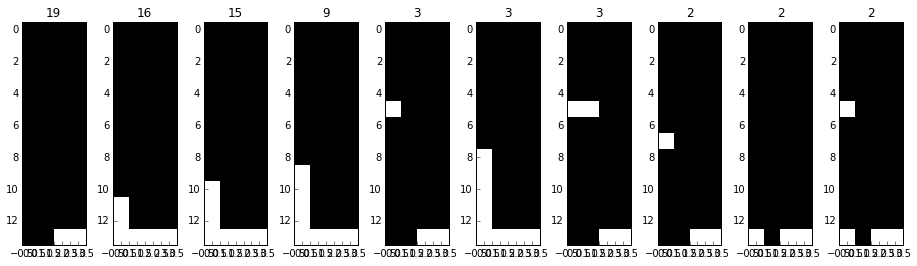

In [247]:
displayclass(d, 11)

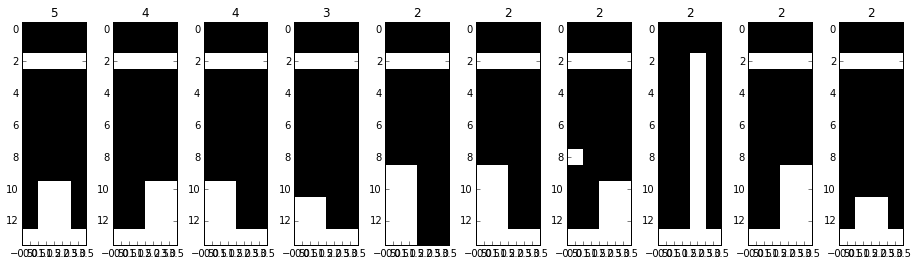

In [248]:
displayclass(d, 12)

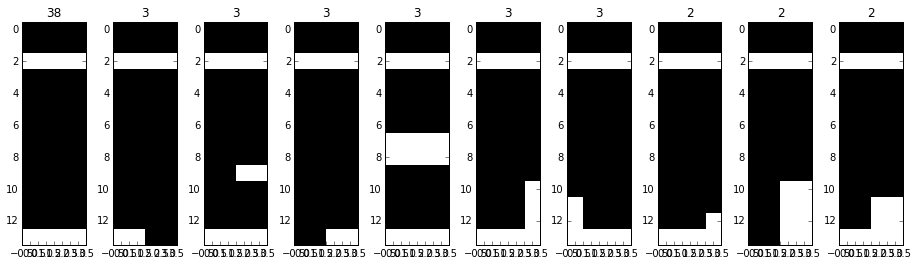

In [249]:
displayclass(d, 13)

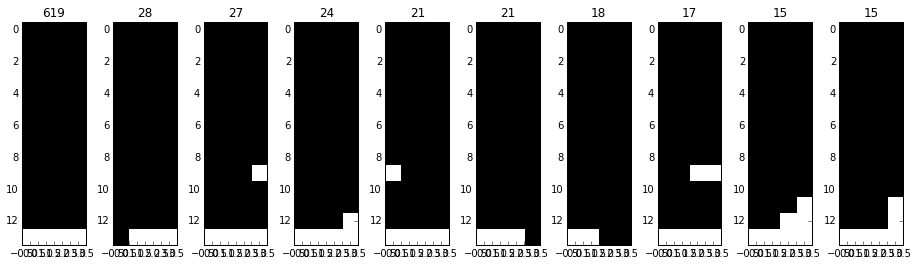

In [250]:
displayclass(d, 15)

In [173]:
model.layers